<a href="https://colab.research.google.com/github/vorst4/temp_repos/blob/master/TUE_5LSM0_g6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Error during restoring latest backup
Iteration 0, loss = 2.6514, time = 00:00:00
Iteration 10, loss = 3.9254, time = 00:00:00
Iteration 20, loss = 11.0824, time = 00:00:01


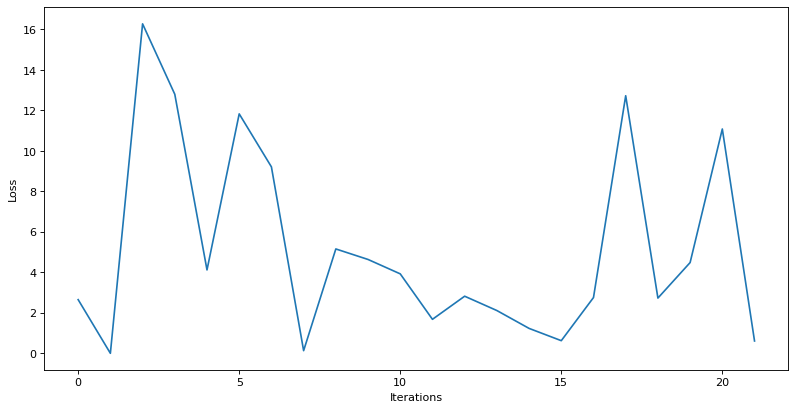

In [78]:
# ------------------------------ Import modules ------------------------------ #

import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from google.colab import drive
from glob import glob
from datetime import datetime

# --------------------------- Functions & Classes ---------------------------- #

def download_and_organize(force=False, 
                          mnt_path='/content/drive', 
                          token_path='/'):
  """
  This function donwloads and organizes the data. More specifically:
  1.  It checks if the folder 'ISIC_2019_Training_Input' exsists. If this is 
      the case, the function will assume that the data is already downloaded 
      and organized and no further action will be taken. If for some reason the
      function needs to be executed anyway, it can be forced (force=True).
  2.  Download the ISIC 2019 data from Kaggle. Your Kaggle token is needed for 
      this. To download your Kaggle token, visit https://www.kaggle.com , then 
      go to 'my account' and then 'download API token'. To pass your Kaggle
      token to the script, Google Drive is used. This way, multiple people can
      run/share the same script without sharing sensitive data. The token 
      should have the name 'kaggle.json' and be placed in Google Drive at the
      path specified by 'token_path'.
  3.  The downloaded data is unziped.
  4.  The train data/images are organized into subfolders. Each image is placed 
      into a subfolder that corresponds to its class. Doing this makes it
      possible to use 'torchvision.datasets.ImageFolder'.
  5.  The zip files and csv files are deleted since they are not needed anymore.

  Note: currently the metadata ignored, meaning it is not linked to the image.   
  
  Args:
    force (bool): force to run the function, even if the data is already 
      downloaded and organized
    mnt_path (string): path where the google drive will be mounted.
    token_path (string): Path on Google Drive where the token can be found.
      With '/' being the root of Google Drive.

  Returns:
    (none)
  """

  # do not download if it already exists
  if os.path.exists('ISIC_2019_Training_Input') and force == False:
    return

  # mount google drive
  print('\nMounting Google Drive...')
  drive.mount(mnt_path, force_remount=True)
  print('...Done')

  # Set kaggle configuration directory
  os.environ['KAGGLE_CONFIG_DIR'] = mnt_path+'/My Drive'+token_path

  # download data
  print('\nDownloading...')
  !kaggle datasets download -d kioriaanthony/isic-2019-training-input
  !kaggle datasets download -d kioriaanthony/isic-2019-training-groundtruth
  !kaggle datasets download -d kioriaanthony/isic-2019-test-input
  # !kaggle datasets download -d kioriaanthony/isic-2019-training-metadata
  # !kaggle datasets download -d kioriaanthony/isic-2019-test-metadata
  print('...Done')

  # unzip it (quietly)
  print('\nUnzipping...')
  !unzip -q isic-2019-training-input.zip
  !unzip -q isic-2019-training-groundtruth.zip
  !unzip -q isic-2019-test-input
  # !unzip -q isic-2019-test-metadata.zip
  # !unzip -q isic-2019-training-metadata.zip
  print('...Done')

  # create subfolders with class name (if they do not exist yet) 
  print('\nCreating subdirs...')
  # path to training and test folder
  paths = ['/content/ISIC_2019_Training_Input/',
           '/content/ISIC_2019_Test_Input/']
  classes = ['mel', 'nv', 'bcc', 'ak', 'bkl', 'df', 'vasc', 'scc', 'unk']
  for path in paths:
    print('creating subdirs in: '+path)
    for clas in classes:
      if not os.path.exists(path+clas):
        os.mkdir(path+clas)
        print('created dir: '+clas)
      else:
        print('dir: '+clas+' already exists')
  print('...Done')

  # obtain the class that corresponds to each img and move it to its folder.
  print('\nReading classing and moving images')
  # Training data
  with open('ISIC_2019_Training_GroundTruth.csv', 'r') as f:
    next(f) # skip header (first line) of .csv file
    for line in f:
      # obtain image name and corresponding class name
      arr = np.array(line.split(','))
      img = arr[0]+'.jpg' # img name
      idx = np.where( arr[1:].astype(np.float) == 1.0 )[0][0] # class-index
      clas = classes[idx]
      # move image (if it exists)
      if os.path.exists(paths[0]+img):
        os.rename(paths[0]+img, paths[0]+clas+'/'+img) # rename = move
      else :
        print('img not found: '+img)
  # Test data (every class is unknown, so move everything to unk)
  for img in glob(paths[1]+'*.jpg'):
    name = img.split('/')[-1]
    os.rename(img, paths[1]+'unk/'+name)
  print('...Done')

  # remove zip & csv files 
  print('\nDeleting zip & csv files...')
  !rm -r sample_data
  !rm -r isic-2019-training-input.zip
  !rm -r isic-2019-training-groundtruth.zip
  !rm -r isic-2019-test-input.zip
  !rm -r isic-2019-training-metadata.zip
  !rm -r isic-2019-test-metadata.zip
  !rm -r ISIC_2019_Training_GroundTruth.csv
  !rm -r ISIC_2019_Training_Metadata.csv
  !rm -r ISIC_2019_Test_Metadata.csv
  print('...Done')


# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .#

def dataloaders(root='/content/',
                train_img_dir='ISIC_2019_Training_Input/',
                test_img_dir='ISIC_2019_Test_Input/',
                batch_size=64,
                validation_size_percentage = 5):
  """
  This function creates and returns dataloaders for the train, validation and 
  test data set.

  Args:
  root (str): root directory
  train_img_dir (str): directory containing images of the training set
  test_img_dir (str): directory that contains the images of the test set
  batch_size (int): batch size
  validation_size_percentage (int, 0...100): the train data is split into train 
    and valuation. This percentage specifies how much of the original data is 
    used as validation. The remaining percentage will be the new train data.
  """

  # dataset transformation. Expand the dataset by adding random horzontal and 
  # vertical flips. 
  # todo: add more data transformations (but not to the test set ofcourse)
  # todo: the training image shapes are either 1024x1024 or 600x450. This is
  #       for the moment hotfixed by resizing it to 32x32. Note that, when 
  #       changing this, the neural net also needs to be changed
  # todo: data normalization
  transform_train = T.Compose([T.RandomHorizontalFlip(), 
                               T.RandomVerticalFlip(),
                               T.Resize((32,32)),  # todo: temporary fix
                               T.ToTensor()])
  transform_test  = T.ToTensor()

  # datasets
  dataset_train = dset.ImageFolder(root+train_img_dir, transform=transform_train)
  dataset_test = dset.ImageFolder(root+test_img_dir, transform=transform_test)

  # split train into validation and (new) train
  N = len(dataset_train.imgs)
  N_train = int(np.round(N*(100-validation_size_percentage)/100))

  # samplers
  sampler_train = sampler.SubsetRandomSampler(range(N_train))
  sampler_val = sampler.SubsetRandomSampler(range(N_train, N))

  # dataloaders
  train = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler_train)
  val = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler_val)
  test = DataLoader(dataset_test, batch_size=batch_size)

  # add bool to see if certain dataset is the training dataset
  train.dataset.train = True
  val.dataset.train = True
  test.dataset.train = False

  return train, val, test, N_train, (N-N_train), len(dataset_test.imgs)


# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .#
    
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1) 

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)


# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .#

def train(model, optimizer, epochs=1):
  """
  Trains the specified model and prints the progress
  
  Args:
  model (...):  model
  optimizer (...): optimizer
  epochs (int): number of epochs to train the model

  Returns:
  (none)
  """
  model = model.to(device=device)  # move the model parameters to CPU/GPU
  model.loss = []
  model.elapsed_time = []
  time_start = time.clock()
      
  for e in range(epochs):
    for t, (x, y) in enumerate(dl_train):
      model.train()  # put model to training mode
      x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
      y = y.to(device=device, dtype=torch.long)
      scores = model(x)
      loss = F.cross_entropy(scores, y)
      
      # Zero out all of the gradients for the variables which the optimizer
      # will update.
      optimizer.zero_grad()

      # backward pass, comput loss gradient
      loss.backward()

      # update parameters using gradients
      optimizer.step()
      
      # append loss 
      model.loss.append(loss)

      # update plot
      if t % print_every == 0:
        time_elapsed = time.strftime('%H:%M:%S', time.gmtime(time.clock()-time_start))
        print('Iteration %d, loss = %.4f, time = %s' % (t, loss.item(), time_elapsed))

      if t>20:
        return()

    my_lr_scheduler.step()
    model.elapsed_time = time.strftime('%H:%M:%S', time.gmtime(time.clock()-time_start))
    print(my_lr_scheduler.get_lr())


# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .#

def visualize():
  fig=plt.figure(figsize=(12, 6), dpi= 80, facecolor='w', edgecolor='k')
  x = np.array(range(len(model.loss)))
  plt.plot(x, model.loss)
  plt.ylabel('Loss')
  plt.xlabel('Iterations')
  plt.show()


# -------------------------------- Neural Net -------------------------------- #

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, 
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, 
                          stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .#

class ResNet(nn.Module):
  def __init__(self, block, num_classes=9):
    super(ResNet, self).__init__()
    self.backup_restore_name_prefix = 'resnet18_'
    self.backup_restore_path = '/content/drive/My Drive/5LSM0-final-assignment/'

    self.in_planes = 64

    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, 
                            bias=False)
    self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._make_layer(block, 64, stride=1)
    self.layer2 = self._make_layer(block, 128, stride=2)
    self.layer3 = self._make_layer(block, 256, stride=2)
    self.layer4 = self._make_layer(block, 512, stride=2)
    self.linear = nn.Linear(512*block.expansion, num_classes)

  def _make_layer(self, block, planes, stride):
    strides = [stride,1] 
    layers = []
    for stride in strides:
      layers.append(block(self.in_planes, planes, stride))
      self.in_planes = planes * block.expansion
    return nn.Sequential(*layers)

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4)
    out = out.view(out.size(0), -1)
    out = self.linear(out)
    return out

  def backup_to_drive(self):
    date_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    path = self.backup_restore_path + self.backup_restore_name_prefix + date_time+'.pt'
    torch.save(model.state_dict(), path)

  def restore_from_drive(self, path):
    self.load_state_dict(torch.load(path))
    self.eval()

  def restore_latest(self):
    models = glob(self.backup_restore_path + self.backup_restore_name_prefix + '*.pt')
    try:
      self.restore_from_drive(models[-1])
    except:
      print('Error during restoring latest backup')


    

# . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .#

def ResNet18():
    return ResNet(BasicBlock)


# ------------------------------ Initialization ------------------------------ #

# check if gpu/tpu is enabled
if torch.cuda.is_available() == False:
  raise ValueError('GPU/TPU not enabled. Goto runtime -> change runtime type')

# use gpu/tpu
device = torch.device('cuda')

# set variable type
dtype = torch.float32

# download data
download_and_organize()

# batch size, increase this until the RAM is full
batch_size = 128 # 128 -> ~100 iterations = 1 epoch
batch_size = 1

# create data loader objects for train, validation and test set. N_epoch is the
# number of images in 1 epoch
dl_train, dl_val, dl_test, N_epoch, N_val, N_test = dataloaders(batch_size=batch_size)

# when to print
print_every = 10


# ----------------------------------- Main ----------------------------------- #

# learning rate (with decay)
# todo: make a script that runs the model with different rates
learning_rate = 1e-2
decayRate = 0.99

# model
model = ResNet18()

# restore last backup of model?
load_backup = True
if load_backup:
  model.restore_latest()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# learning rate
my_lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, 
                                                         gamma=decayRate)

# train
train(model, optimizer, epochs=1)

# visualize results
visualize()

# # save obtained model
# model.backup_to_drive()


# ----------------------------------- End ------------------------------------ #
